In [49]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import (ModelSpec as MS,summarize)
from sklearn.tree import (DecisionTreeClassifier as DTC,DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF,GradientBoostingRegressor as GBR,
                             GradientBoostingClassifier as GBC,
                             BaggingClassifier as BC)
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ISLP
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,summarize)
import seaborn as sns
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [15]:
oj=load_data("OJ")

In [16]:
len(oj[((oj['Store7'] == 'Yes') & (oj['STORE'] == 1)) | ((oj['Store7'] == 'No') & (oj['STORE'] == 0))])

0

In [17]:
model = MS(oj.columns.drop(['Purchase','Store7']), intercept=False)
D = model.fit_transform(oj)
feature_names = list(D.columns)
X = np.asarray(D)

In [18]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(X,oj['Purchase'],train_size = 800, random_state = 0)

In [19]:
clf = DTC(criterion = 'entropy', random_state = 0)
result=clf.fit(X_train, y_train)

In [20]:
training_error = 1 - accuracy_score(y_train, clf.predict(X_train))
training_error

0.008750000000000036

The training error is 0.87% which is suspiciously low.

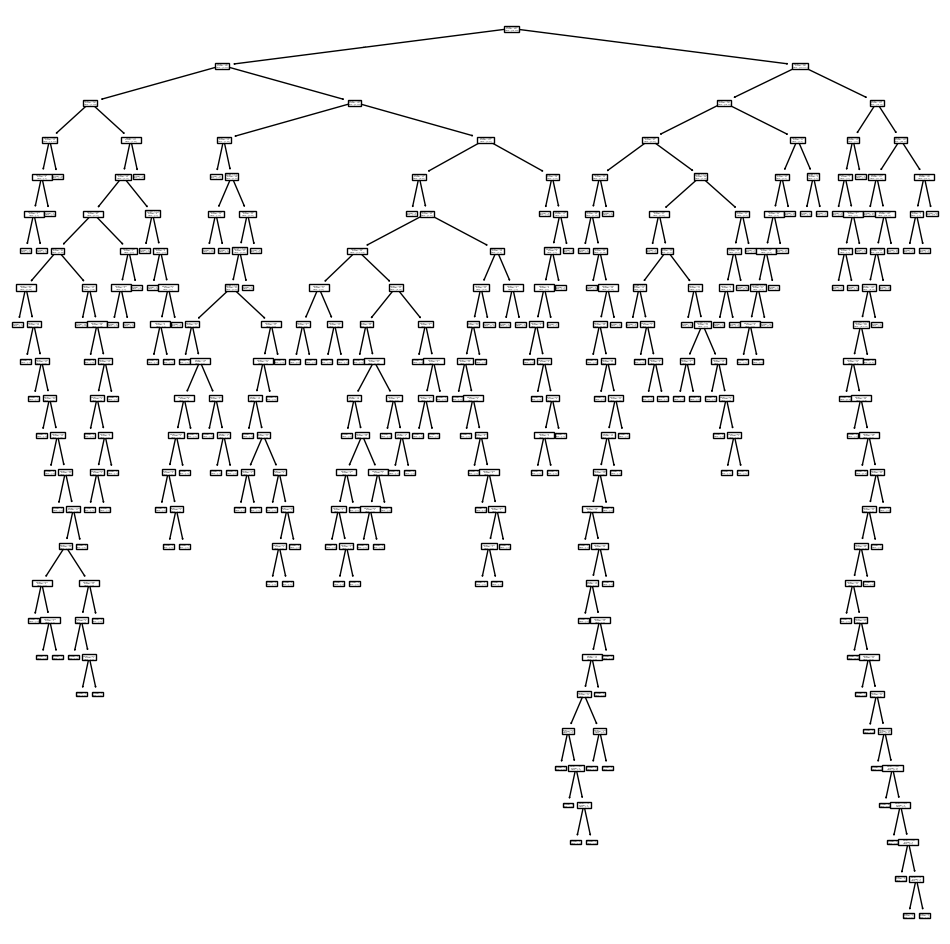

In [21]:
ax = subplots(figsize = (12, 12))[1]
plot_tree(clf,feature_names = feature_names,ax = ax);

In [22]:
clf.tree_.n_leaves

np.int64(171)

The number of terminal nodes is 171.

In [23]:
print(export_text(clf,feature_names=feature_names,show_weights=True))

|--- LoyalCH <= 0.51
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.04
|   |   |   |--- StoreID <= 2.50
|   |   |   |   |--- WeekofPurchase <= 269.50
|   |   |   |   |   |--- WeekofPurchase <= 267.50
|   |   |   |   |   |   |--- weights: [0.00, 2.00] class: MM
|   |   |   |   |   |--- WeekofPurchase >  267.50
|   |   |   |   |   |   |--- weights: [1.00, 0.00] class: CH
|   |   |   |   |--- WeekofPurchase >  269.50
|   |   |   |   |   |--- weights: [0.00, 3.00] class: MM
|   |   |   |--- StoreID >  2.50
|   |   |   |   |--- weights: [0.00, 43.00] class: MM
|   |   |--- LoyalCH >  0.04
|   |   |   |--- WeekofPurchase <= 273.50
|   |   |   |   |--- SalePriceCH <= 1.94
|   |   |   |   |   |--- WeekofPurchase <= 263.50
|   |   |   |   |   |   |--- STORE <= 1.50
|   |   |   |   |   |   |   |--- WeekofPurchase <= 228.00
|   |   |   |   |   |   |   |   |--- weights: [1.00, 0.00] class: CH
|   |   |   |   |   |   |   |--- WeekofPurchase >  228.00
|   |   |   |   |   |   |   |   |--- LoyalCH

In [24]:
confusion = confusion_table(clf.predict(X_test),y_test)
confusion

Truth,CH,MM
Predicted,,
CH,126,33
MM,27,84


In [25]:
test_error=(confusion.iloc[0,1]+confusion.iloc[1,0])/np.sum(confusion.values)
test_error

np.float64(0.2222222222222222)

The test error is 22.22% which is way higher than the training error.

In [26]:
M = np.zeros(clf.get_depth())
for i in range(1, clf.get_depth() + 1):
    clf1 = DTC(criterion = 'entropy', random_state = 20,max_depth = i)
    results1 = skm.cross_val_score(clf1, X_train, y_train,cv = 10)#10-fold
    M[i - 1] = results1.mean()
print('The optimal tree size is', M.argmax() + 1)

The optimal tree size is 3


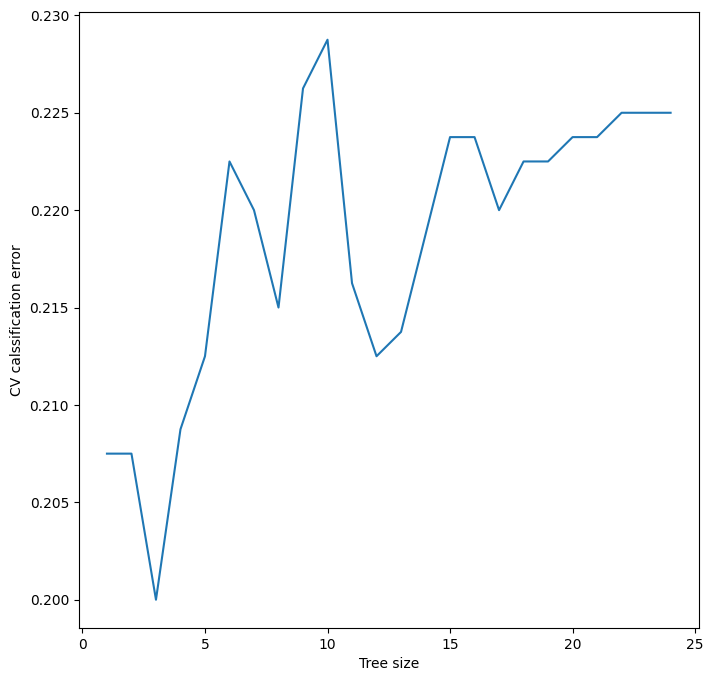

In [27]:
fig,ax=subplots(figsize=(8,8))
ax.plot(range(1,clf.get_depth()+1),1-M)
ax.set_xlabel("Tree size")
ax.set_ylabel("CV calssification error");

The best tree size is 3.

In [28]:
clf_pruned = DTC(criterion = 'entropy', random_state = 20,max_depth = M.argmax() + 1)
clf_pruned.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=np.int64(3),
                       random_state=20)

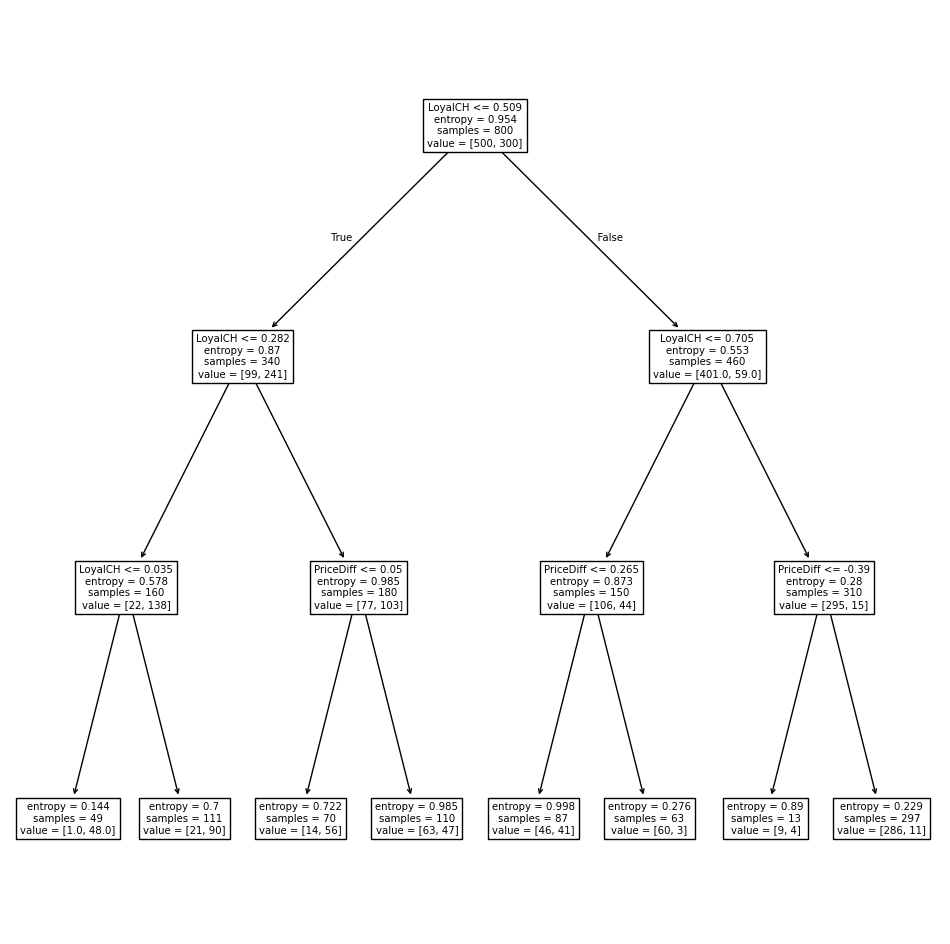

In [29]:
ax = subplots(figsize = (12, 12))[1]
plot_tree(clf_pruned, feature_names = feature_names, ax = ax);

In [30]:
training_error_pruned = 1 - accuracy_score(y_train, clf_pruned.predict(X_train))
training_error_pruned

0.1775

The training error is 17.75%

In [31]:
test_error_pruned = 1 - accuracy_score(y_test, clf_pruned.predict(X_test))
test_error_pruned

0.18888888888888888

Now the test error is better than before at 18.88%

In [32]:
Hitters = load_data('Hitters')

In [33]:
Hitters = Hitters.dropna()

In [34]:
Hitters['League'] = np.where(Hitters['League'] == 'A', 1, 0)
Hitters['Division'] = np.where(Hitters['Division'] == 'E', 1, 0)
Hitters['NewLeague'] = np.where(Hitters['NewLeague'] == 'A', 1, 0)

In [35]:
Hitters['LogSalary'] = np.log(Hitters['Salary'])

In [36]:
X = Hitters.drop(['Salary', 'LogSalary'], axis = 1)
y = Hitters['LogSalary']
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, y ,train_size=200,
                                                          random_state=1)

In [37]:
lambdagrid = np.linspace(0.001, 0.04)
#Typical values of lambda range between 0.001 and 0.01 according to
# page 349 of the book. We chose 0.04 insetead of 0.01 to show the stabilization of training MSE

training_mse = np.zeros(lambdagrid.shape[0])
for i in range(lambdagrid.shape[0]):
    boost_Hitters = GBR(n_estimators = 1000, learning_rate = lambdagrid[i],random_state = 3)
    boost_Hitters.fit(X_train, y_train)
    training_mse[i] = np.mean((y_train - boost_Hitters.predict(X_train)) ** 2)

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Camer\AppData\Local\Temp\ipykernel_912\3209154464.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$')


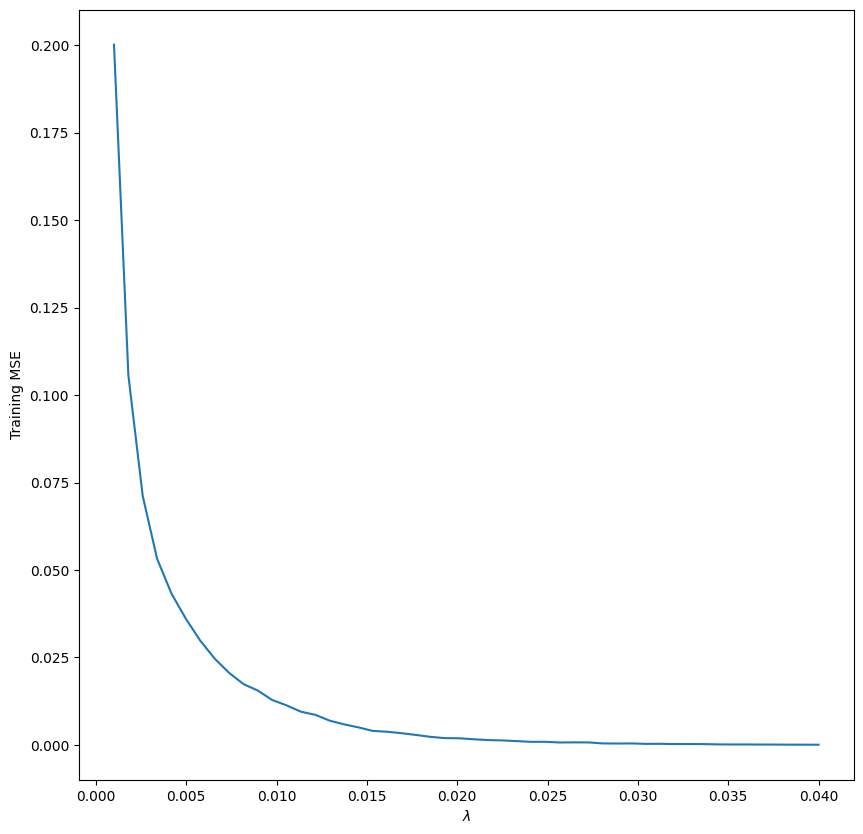

In [38]:
fig, ax = subplots(figsize = (10, 10))
ax.plot(lambdagrid, training_mse)
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Training MSE');

In [39]:
test_mse = np.zeros(lambdagrid.shape[0])
for i in range(lambdagrid.shape[0]):
    boost_Hitters = GBR(n_estimators = 1000, learning_rate = lambdagrid[i],random_state = 3)
    boost_Hitters.fit(X_train, y_train)
    test_mse[i] = np.mean((y_test - boost_Hitters.predict(X_test)) ** 2)

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Camer\AppData\Local\Temp\ipykernel_912\1617190645.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$')


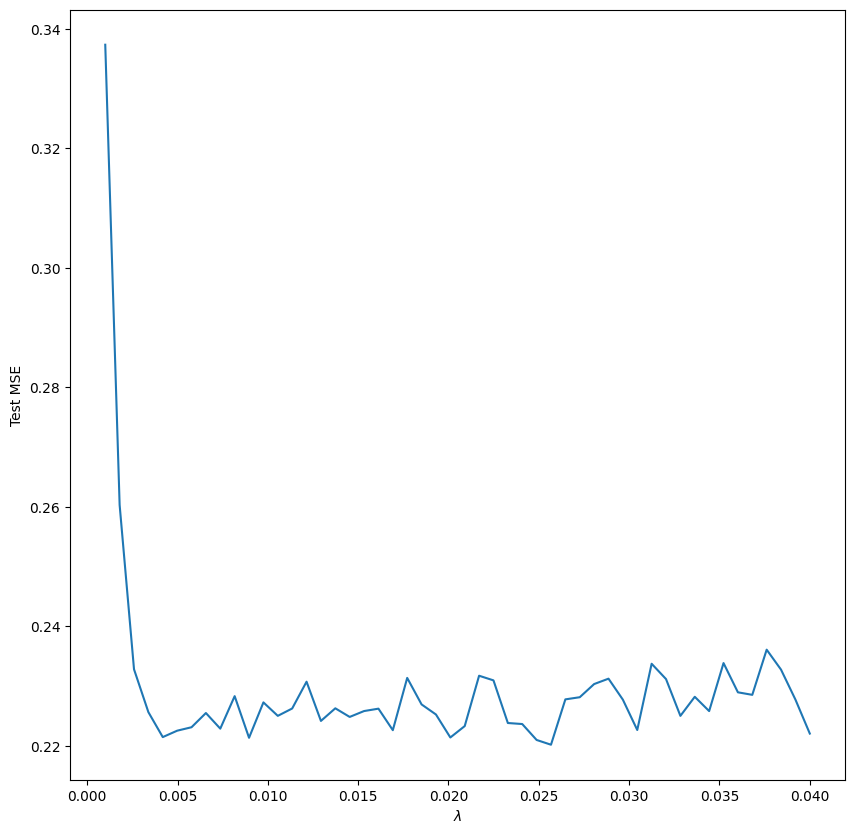

In [40]:
fig, ax = subplots(figsize = (10, 10))
ax.plot(lambdagrid, test_mse)
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Test MSE');

In [41]:
mlr_Hitters = LinearRegression().fit(X_train, y_train)
mlr_testmse=np.mean((y_test- mlr_Hitters.predict(X_test))**2)

In [42]:
ridge_Hitters=Ridge().fit(X_train,y_train)
ridge_testmse=np.mean((y_test- ridge_Hitters.predict(X_test))**2)

In [43]:
model=['Multiple linear regression','Ridge','Boosting']
df=pd.DataFrame({'Test Mse':[mlr_testmse,ridge_testmse,min(test_mse)]},index=model)
df

,Test Mse
Multiple linear regression,0.452639
Ridge,0.454074
Boosting,0.220185


The best MSE is obtained by boosting by a lot.

In [44]:
best_lmabda=lambdagrid[test_mse.argmin()]
boost_Hitters_opt = GBR(n_estimators=1000,learning_rate=best_lmabda,random_state=10)
boost_Hitters_opt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=np.float64(0.025673469387755103),
                          n_estimators=1000, random_state=10)

In [45]:
X_train.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object')

In [46]:
feature_names=X_train.columns
feature_imp = pd.DataFrame({'importance':boost_Hitters_opt.feature_importances_},index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
CAtBat,0.436033
CHits,0.169179
AtBat,0.063362
CHmRun,0.062273
RBI,0.041733
CRBI,0.036453
CRuns,0.033348
CWalks,0.029465
Hits,0.024916
PutOuts,0.021996


The top 3 predictors are CAtBat, CHits, and AtBat

In [47]:
bag_Hitters = RF(max_features=X_train.shape[1], random_state=10)
bag_Hitters.fit(X_train, y_train)

RandomForestRegressor(max_features=19, random_state=10)

In [48]:
bag_MSE=np.mean((y_test - bag_Hitters.predict(X_test))**2)
bag_MSE

np.float64(0.2502380573947847)

The test MSE by bagging is 0.25 which is slightly larger than the test MSE from boosting.

In [50]:
Weekly=load_data("Weekly")

In [51]:
allvars=Weekly.columns.drop(['Today','Direction','Year'])
design=MS(allvars)
X=design.fit_transform(Weekly)
y=Weekly.Direction=='Up'
glm=sm.GLM(y,X,family=sm.families.Binomial())
res=glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                            GLM   Df Residuals:                     1082
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -743.18
Date:                Thu, 08 May 2025   Deviance:                       1486.4
Time:                        12:57:39   Pearson chi2:                 1.09e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.009000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

Lag2 is the only significant predictor.

In [52]:
probs=res.predict()
labels=np.array(['Down']*1089)
labels[probs>0.5]="Up"

In [53]:
ISLP.confusion_table(labels,Weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [54]:
(557+54)/(54+557+430+48)

0.5610651974288338

The accuracy rate is 56% which is only slightly better than random guessing.  Our error rate is mostly due to false positives.

In [56]:
train=(Weekly.Year<2009)
W_train=Weekly.loc[train].Lag2
W_test=Weekly.loc[~train].Lag2
W_test.shape

(104,)

In [57]:
X_train, X_test = X.loc[train].Lag2, X.loc[~train].Lag2
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
#Designing the probabilities based on the training set
probs = results.predict(exog=X_test)

X_t=np.array(X_train)
XX=X_t.reshape(np.shape(X_t)[0],1)
X_ts=np.array(X_test)
Xts=X_ts.reshape(np.shape(X_ts)[0],1)

In [59]:
D=Weekly.Direction
Test_set=D.loc[~train]
Train_set=D.loc[train]
#Converting the probs matrix to a matrix filled with direction values
labels=np.array(['Down']*104)
labels[probs>0.5]='Up'
C=ISLP.confusion_table(labels,Test_set)
Train_s=np.array(Train_set)
TT=Train_s.reshape(np.shape(Train_set)[0],1)
Test_s=np.array(Test_set)
TS=Test_s.reshape(np.shape(Test_s)[0],1)
TS.shape

(104, 1)

In [61]:
C

Truth,Down,Up
Predicted,,
Down,20,24
Up,23,37


The accuracy rate on the holdout data is about 55%.

In [62]:
Auto=load_data("Auto")

In [63]:
mpg01=np.where(Auto["mpg"]>Auto["mpg"].median(),1,0)

In [64]:
Auto['mpg01']=mpg01

In [65]:
Auto.corr(numeric_only=True)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209,0.836939
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932,-0.759194
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535,-0.753477
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171,-0.667053
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005,-0.757757
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746,0.346822
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528,0.429904
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000,0.513698
mpg01,0.836939,-0.759194,-0.753477,-0.667053,-0.757757,0.346822,0.429904,0.513698,1.000000


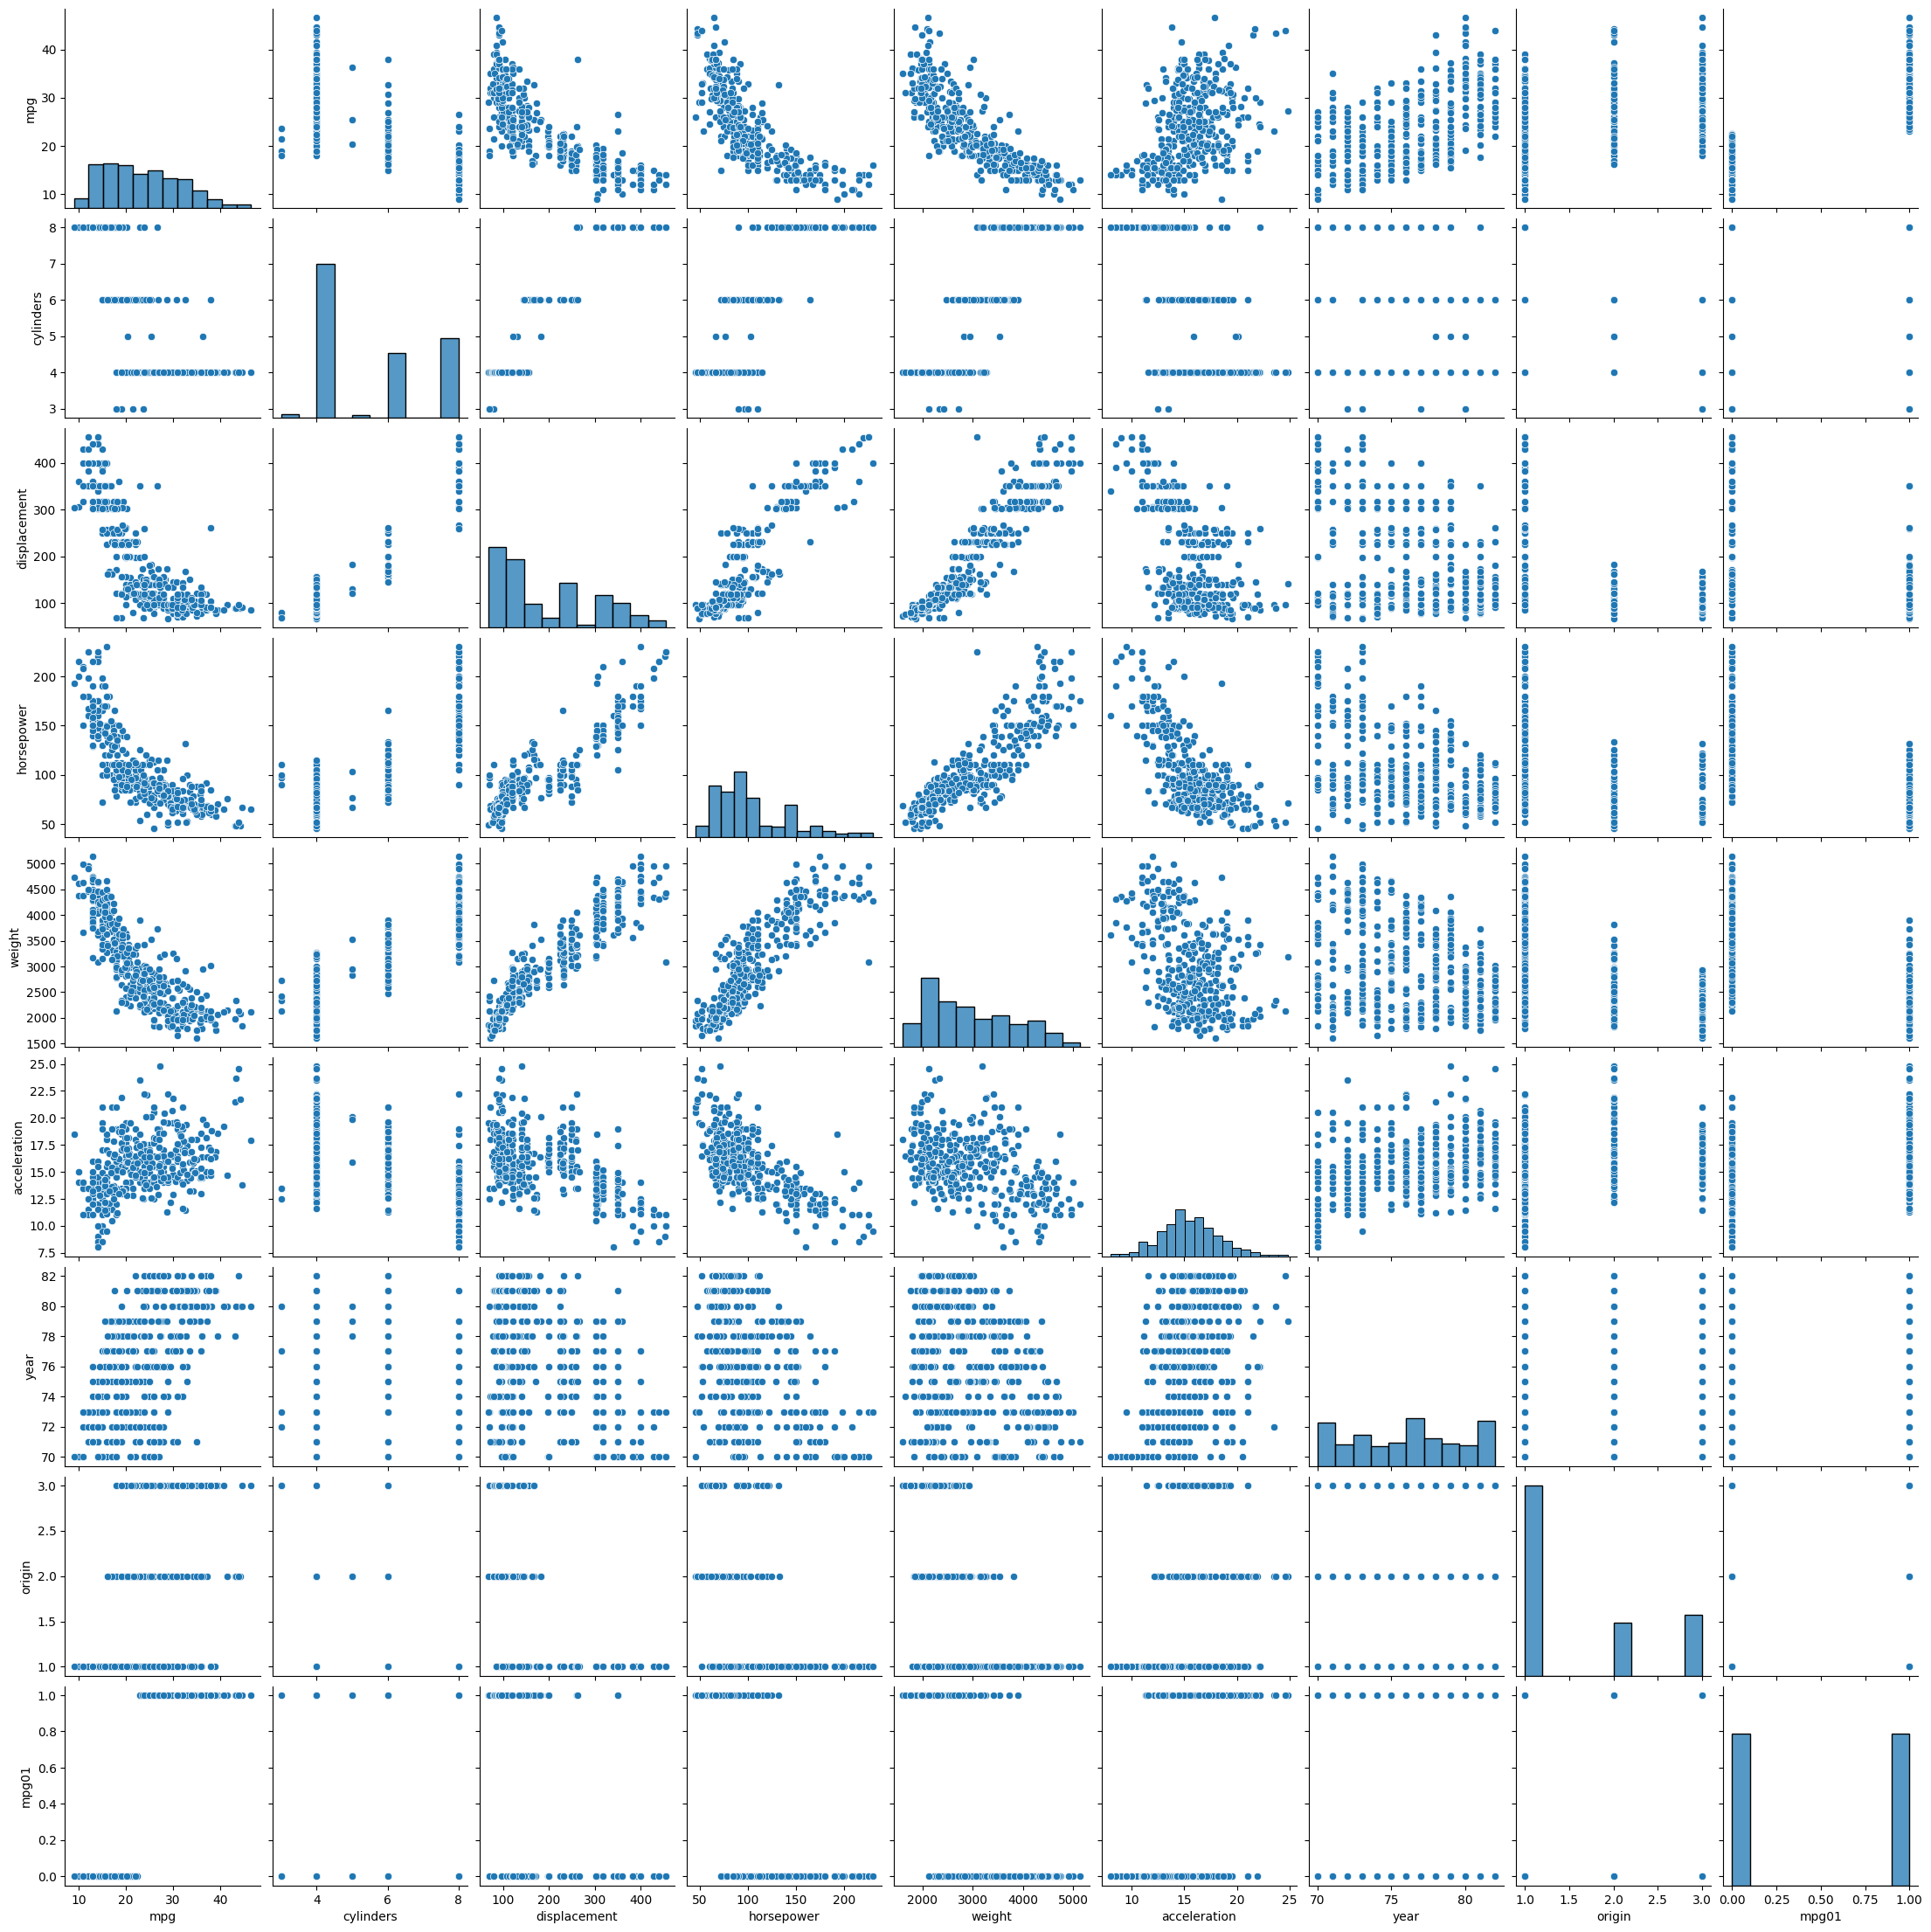

In [66]:
sns.pairplot(Auto);

From the graph and correlation matrix we can determine that mpg01, displacement, weight, and cylinders are significant.

In [67]:
x=Auto[['weight','displacement','cylinders']].values
#the values attribute is used to convert x from a dataframe object to an array
y=Auto['mpg01'].values

In [68]:
(X_train,X_test,y_train,y_test) = train_test_split(x,y,random_state=1)

In [69]:
lr=LogisticRegression()
result=lr.fit(X_train,y_train)
lr_test_error=1-accuracy_score(y_test, lr.predict(X_test))
lr_test_error

0.061224489795918324

The test error from our logistic regression model is roughly 6%.